In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
results = session.query(Measurement.date, Measurement.prcp).all()

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

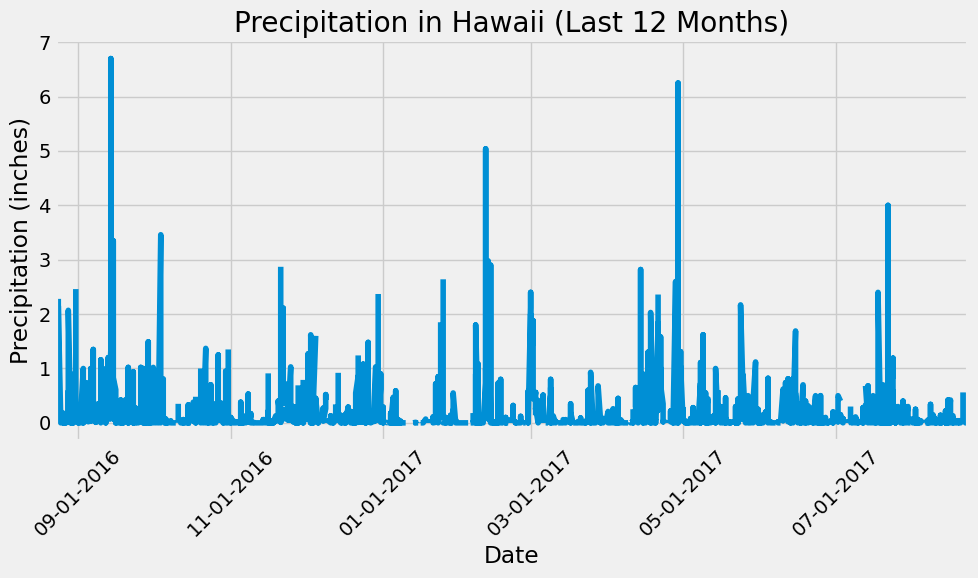

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
most_recent_date = pd.to_datetime(most_recent_date)
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Perform a query to retrieve the data and precipitation scores
precipitation_df = pd.DataFrame(results, columns=['date', 'precipitation'])
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])  # Convert the 'date' column to datetime format
precipitation_df = precipitation_df[precipitation_df['date'] >= one_year_ago]  # Filter data for the last 12 months
precipitation_df = precipitation_df[precipitation_df['date'] <= most_recent_date]  # Filter data until most_recent_date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility
plt.plot(precipitation_df['date'], precipitation_df['precipitation'])
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in Hawaii (Last 12 Months)")
plt.gca().xaxis.set_major_formatter(DateFormatter('%m-%d-%Y'))  # Format x-axis dates
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Sort the dataframe by date
# Set x-axis limits to show data from 2016-08-23 to 2017-08-23
plt.xlim(pd.Timestamp('2016-08-23'), pd.Timestamp('2017-08-23'))

plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df = pd.DataFrame(results,columns=['date','prcp'])
summary_statistics= precipitation_df['prcp'].describe()
summary_statistics

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.station))\
                 .group_by(Measurement.station)\
                 .order_by(func.count(Measurement.station).desc())\
                 .all()

for station, count in results:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = results[0][0]  # Assuming the most active station ID is in the first row of the previous query

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                           .filter(Measurement.station == most_active_station)\
                           .all()

# Unpack the result
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the result
print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


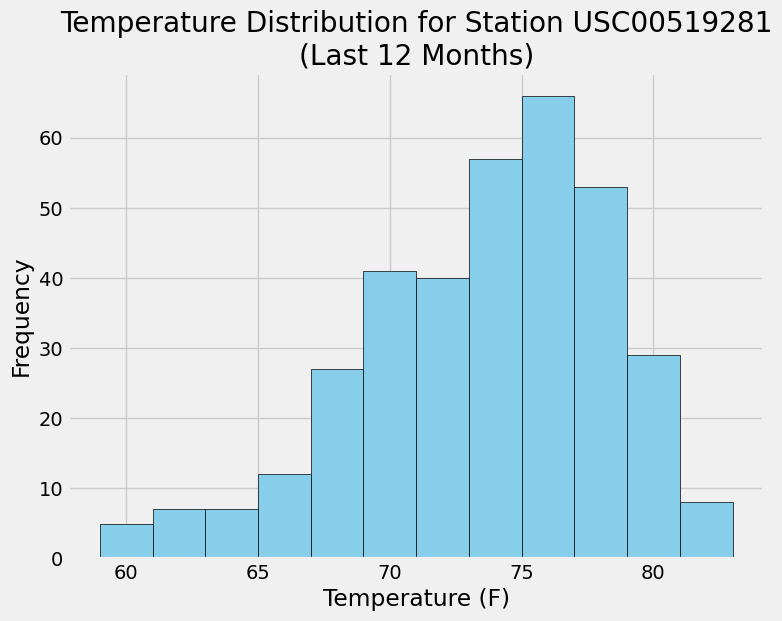

In [28]:
# Step 1: Query the last 12 months of temperature observation data for the most active station
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Query the temperature data for the last 12 months for the most active station
temperature_data = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= dt.date(2016,8,23)).all()
#.filter(Measurement.date >= one_year_ago).filter(Measurement.date <= most_recent_date).\

# Step 2: Extract temperatures from the query result and create a DataFrame
temperatures = [temp[0] for temp in temperature_data]
temperature_df = pd.DataFrame({'Temperature': temperatures})

# Step 3: Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Distribution for Station {most_active_station}\n(Last 12 Months)')
plt.show()


# Close Session

In [29]:
# Close Session
session.close()